In [1]:
import pandas as pd
from tokenizers.pre_tokenizers import Whitespace
pre_tokenizer = Whitespace()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import torch
import torch.nn as nn # Contains all the functions we need to to train our network
import torch.nn.functional as F # Contains some additional functions such as activations
from torch.autograd import Variable

In [3]:
from transformers import BertModel
model_name = "bert-base-uncased"
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

In [5]:
data = pd.read_csv("C:/Users/______/Desktop/GDL project/yelp.csv")

In [6]:
device = "cuda:0"

In [7]:
print(data.shape)

print(data.columns)

print(data.head())

(10000, 10)
Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny'],
      dtype='object')
              business_id        date               review_id  stars   
0  9yKzy9PApeiPPOUJEtnvkg  2011-01-26  fWKvX83p0-ka4JS3dc6E5A      5  \
1  ZRJwVLyzEJq1VAihDhYiow  2011-07-27  IjZ33sJrzXqU-0X6U8NwyA      5   
2  6oRAC4uyJCsJl1X0WZpVSA  2012-06-14  IESLBzqUCLdSzSqm0eCSxQ      4   
3  _1QQZuf4zZOyFCvXc0o6Vg  2010-05-27  G-WvGaISbqqaMHlNnByodA      5   
4  6ozycU1RpktNG2-1BroVtw  2012-01-05  1uJFq2r5QfJG_6ExMRCaGw      5   

                                                text    type   
0  My wife took me here on my birthday for breakf...  review  \
1  I have no idea why some people give bad review...  review   
2  love the gyro plate. Rice is so good and I als...  review   
3  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...  review   
4  General Manager Scott Petello is a good egg!!!...  review   

                  user_id  cool  u

In [8]:
def get_words(strr):
    words = strr.replace(".", " ")
    word_list = words.split(" ")
    return len(word_list)

In [9]:
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
data['length'] = data['text'].apply(get_words)
data.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,171
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,274
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,17
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,79
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,102


In [10]:
data["maxl"] = data["text"].apply(lambda x: max(map(len,x.split('.'))))
data.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length,maxl
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,171,135
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,274,201
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,17,56
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,79,172
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,102,279


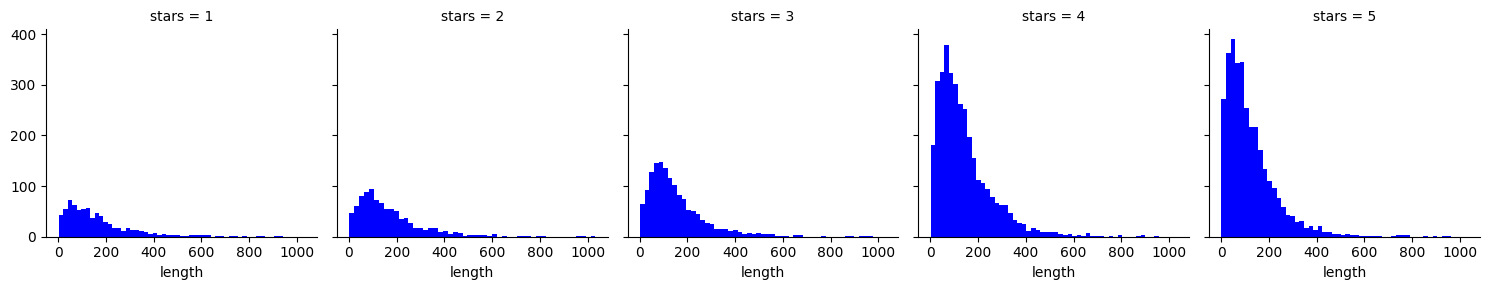

In [11]:
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=data,col='stars')
graph.map(plt.hist,'length',bins=50,color='blue')

In [12]:
# GETTING THE MEAN VALUES OF THE VOTE COLUMNS WRT THE STARS ON THE REVIEW
stval = data.groupby('stars')
stval.mean(True)

,cool,useful,funny,length,maxl
stars,,,,,
1,0.576769,1.604806,1.056075,167.941255,163.433912
2,0.719525,1.563107,0.875944,170.721683,163.048544
3,0.788501,1.306639,0.694730,154.157426,152.344285
4,0.954623,1.395916,0.670448,142.790698,155.195406
5,0.944261,1.381780,0.608631,124.482769,156.760264


In [13]:
stval.count()

,business_id,date,review_id,text,type,user_id,cool,useful,funny,length,maxl
stars,,,,,,,,,,,
1,749,749,749,749,749,749,749,749,749,749,749
2,927,927,927,927,927,927,927,927,927,927,927
3,1461,1461,1461,1461,1461,1461,1461,1461,1461,1461,1461
4,3526,3526,3526,3526,3526,3526,3526,3526,3526,3526,3526
5,3337,3337,3337,3337,3337,3337,3337,3337,3337,3337,3337


In [14]:
stval.corr(numeric_only=True)

cool    useful     funny    length      maxl
stars                                                         
1     cool    1.000000  0.759015  0.802161  0.268091  0.194253
      useful  0.759015  1.000000  0.667355  0.325898  0.236515
      funny   0.802161  0.667355  1.000000  0.256482  0.170644
      length  0.268091  0.325898  0.256482  1.000000  0.579887
      maxl    0.194253  0.236515  0.170644  0.579887  1.000000
2     cool    1.000000  0.785922  0.826350  0.269454  0.266398
      useful  0.785922  1.000000  0.669214  0.304540  0.232282
      funny   0.826350  0.669214  1.000000  0.255107  0.283420
      length  0.269454  0.304540  0.255107  1.000000  0.483595
      maxl    0.266398  0.232282  0.283420  0.483595  1.000000
3     cool    1.000000  0.853302  0.832051  0.252712  0.217422
      useful  0.853302  1.000000  0.760241  0.290980  0.247937
      funny   0.832051  0.760241  1.000000  0.252378  0.211076
      length  0.252712  0.290980  0.252378  1.000000  0.528993
      maxl    0.217422  0.247937  0.211076  0.528993  1.000000
4     cool    1.000000  0.902031  0.851593  0.274769  0.202739
      useful  0.902031  1.000000  0.794473  0.307464  0.208096
      funny   0.851593  0.794473  1.000000  0.236706  0.170999
      length  0.274769  0.307464  0.236706  1.000000  0.541772
      maxl    0.202739  0.208096  0.170999  0.541772  1.000000
5     cool    1.000000  0.926913  0.718411  0.235009  0.137575
      useful  0.926913  1.000000  0.692654  0.275695  0.156358
      funny   0.718411  0.692654  1.000000  0.249240  0.146321
      length  0.235009  0.275695  0.249240  1.000000  0.496588
      maxl    0.137575  0.156358  0.146321  0.496588  1.000000

In [15]:
# CLASSIFICATION
data_classes = data[(data['stars']==1) | (data['stars']==3) | (data['stars']==5)]
data_classes.head()
print(data_classes.shape)

(5547, 12)


In [28]:
data_classes = data_classes[data_classes["maxl"]<100]
data_classes = data_classes[data_classes["length"]<200]

In [29]:
data_classes

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length,maxl
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,171,135
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,79,172
9,nMHhuYan8e3cONo3PornJA,2010-08-11,jJAIXA46pU1swYyRCdfXtQ,5,Nobuo shows his unique talents with everything...,review,sUNkXg8-KFtCMQDV6zRzQg,0,1,0,38,58
10,AsSCv0q_BWqIe3mX2JqsOQ,2010-06-16,E11jzpKz9Kw5K7fuARWfRw,5,The oldish man who owns the store is as sweet ...,review,-OMlS6yWkYjVldNhC31wYg,1,3,1,59,71
11,e9nN4XxjdHj4qtKCOPq_vg,2011-10-21,3rPt0LxF7rgmEUrznoH22w,5,Wonderful Vietnamese sandwich shoppe. Their ba...,review,C1rHp3dmepNea7XiouwB6Q,1,1,0,63,99
...,...,...,...,...,...,...,...,...,...,...,...,...
9990,R8VwdLyvsp9iybNqRvm94g,2011-10-03,pcEeHdAJPoFNF23es0kKWg,5,Yes I do rock the hipster joints. I dig this ...,review,b92Y3tyWTQQZ5FLifex62Q,1,1,1,66,92
9991,WJ5mq4EiWYAA4Vif0xDfdg,2011-12-05,EuHX-39FR7tyyG1ElvN1Jw,5,Only 4 stars? \n\n(A few notes: The folks that...,review,hTau-iNZFwoNsPCaiIUTEA,1,1,0,177,167
9992,f96lWMIAUhYIYy9gOktivQ,2009-03-10,YF17z7HWlMj6aezZc-pVEw,5,I'm not normally one to jump at reviewing a ch...,review,W_QXYA7A0IhMrvbckz7eVg,2,3,2,280,142
9995,VY_tvNUCCXGXQeSvJl757Q,2012-07-28,Ubyfp2RSDYW0g7Mbr8N3iA,3,First visit...Had lunch here today - used my G...,review,_eqQoPtQ3e3UxLE4faT6ow,1,2,0,132,115


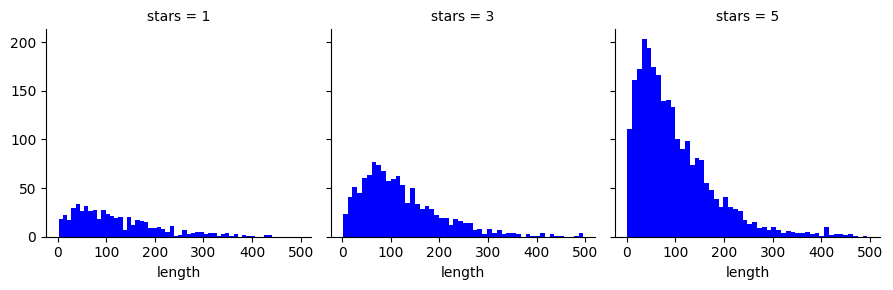

In [30]:
graph = sns.FacetGrid(data=data_classes,col='stars')
graph.map(plt.hist,'length',bins=50,color='blue')

In [31]:
stval2 = data_classes.groupby('stars')
stval2.mean(True)

,cool,useful,funny,length,maxl
stars,,,,,
1,0.441652,1.346499,0.827648,120.978456,125.267504
3,0.607517,1.064685,0.510490,121.050699,121.980769
5,0.796101,1.198830,0.498246,98.076803,118.132554


In [32]:
stval2.count()

,business_id,date,review_id,text,type,user_id,cool,useful,funny,length,maxl
stars,,,,,,,,,,,
1,557,557,557,557,557,557,557,557,557,557,557
3,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144
5,2565,2565,2565,2565,2565,2565,2565,2565,2565,2565,2565


train and test

In [33]:
data_train = pd.concat([data_classes[data_classes["stars"]==i][0:333] for i in (1,3,5)])

In [34]:
gb = data_train.groupby("length")

In [35]:
gb.count()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,maxl
length,,,,,,,,,,,
2,5,5,5,5,5,5,5,5,5,5,5
3,4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4,4
7,6,6,6,6,6,6,6,6,6,6,6
8,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
435,1,1,1,1,1,1,1,1,1,1,1
439,1,1,1,1,1,1,1,1,1,1,1
450,1,1,1,1,1,1,1,1,1,1,1


not much use batching sentences of same length :(

In [37]:
# Seperate the dataset into X and Y for prediction
x = data_train['text']
y = data_train['stars']
print(x.head())
print(y.head())

31    Disgusting!  Had a Groupon so my daughter and ...
61    I have always been a fan of Burlington's deals...
64    Another night meeting friends here.  I have to...
65    Not busy at all but took nearly 45 min to get ...
71    Yikes, reading other reviews I realize my bad ...
Name: text, dtype: object
31    1
61    1
64    1
65    1
71    1
Name: stars, dtype: int64


In [38]:
x_short = x.reset_index(drop=True)
y_short = y.reset_index(drop=True)
i=0

In [123]:
@torch.no_grad()
def bert_encode(sentences):
    toks = tokenizer.encode(sentences,return_tensors="pt")
    return model(toks[:,0:min(512,toks.shape[1])]).last_hidden_state

In [124]:
def list_encode(x):
    global i
    i+=1
    if i%50==0:
        print(i)
    return list(map(bert_encode, list( map( lambda x: x+".",x.split(".") ) ) )  )

In [125]:
def reg_encode(x):
    global i
    i+=1
    if i%50==0:
        print(i)
    return bert_encode(x)

In [126]:
embeddings= x_short.apply(reg_encode)#embed entire review - so each row is a tensor

50
100
150
200
250
300


KeyboardInterrupt: 

maxx = 0
for j in range(999):
    for i in embeddings[j]:
        maxx = max(maxx, i.shape[1])

print(maxx)

In [43]:
embeddings[0].shape

torch.Size([1, 82, 768])

a failed attempt to do pos encoding before handing to the model

def pos_encode_list(lst, method):
    """returns Tensors in non-downsample case, list of tensors otherwise.
    Had to rewrite so that classification token will get correct pos"""
    list_len = len(lst)
    dim = lst[0].shape[2]
    global j
    j+=1
    if j%50==0:
        print(j)
    if method == "1D":
        data = torch.cat(lst,1)
        pos = torch.unsqueeze(get_positional_embeddings(data.shape[1]+1,data.shape[2])[1:],0)
        return data + pos

    elif method == "2D":
        newlst=[]
        assert dim%2 ==0
        dim = dim//2
        part_1 = get_positional_embeddings(list_len+1,dim)[1:]
        for i, elem in enumerate(lst):
            sublist_len = elem.shape[1]
            part_2 = get_positional_embeddings(sublist_len,dim)
            pos = torch.cat((part_1[i].expand(sublist_len,-1),part_2),1)
            newlst.append(elem+torch.unsqueeze(pos,0))
        return torch.cat(newlst,1)
    
    elif method == "downsampling":
        new_lst = []
        for i, elem in enumerate(lst):
            pos = torch.unsqueeze(get_positional_embeddings(elem.shape[1]+1,elem.shape[2])[1:],0)
            new_lst.append(pos+elem)
        return new_lst

j=0

catted = embeddings.apply(lambda x:pos_encode_list(x,"1D"))

maxx = 0
for j in catted:
    maxx = max(maxx, j.shape[1])#should hopefully be 200 - nope im stupid. didn't put limit on total rev length

maxx

catted.shape

for i in embeddings[0]:
    print( i.shape)

get_positional_embeddings(100,10)[0]

get_positional_embeddings(100,20)[0]

In [100]:
def list_to_pad_tens(lst,maxl):
    """for use in downsampled case"""
    #max(list(map(lambda x: x.shape[1], lst)))
    newl = []
    for tens in lst:
        pad = torch.zeros(tens.shape[0],maxl-tens.shape[1],tens.shape[2])
        newt = torch.cat((tens, pad),1)
        newl.append(newt)
    return torch.cat(newl)

list_to_pad_tens(embeddings[0]).shape

padded_cat = list_to_pad_tens(catted,900)

padded_cat.shape

embeddings_padded = embeddings.apply(lambda x: list_to_pad_tens(x, 200))

embeddings_padded[0].shape

In [44]:
def to_one_hot(elem):
    lst = [elem==i for i in [1,3,5]]
    return torch.Tensor(lst)

In [45]:
y_proper = y_short.apply(to_one_hot)

In [46]:
# y_proper = y_short.apply(lambda x: x//2)

In [47]:
y_proper.tolist()

[tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.]),
 tensor([1.

In [617]:
# y_proper
#embeddings_padded[3]

In [49]:
x_train = pd.concat((embeddings[0:300],embeddings[333:633],embeddings[666:966]))

In [50]:
y_train = pd.concat((y_proper[0:300],y_proper[333:633] ,y_proper[666:966]))

In [51]:
x_test = pd.concat((embeddings[300:333],embeddings[633:666],embeddings[966:999]))

In [52]:
y_test = pd.concat((y_proper[300:333],y_proper[633:666] ,y_proper[966:999]))

#x_train.index

Tensor(y_proper)

#x_train

def train_split(X,Y):
    y = torch.cat(list(map(lambda x: torch.unsqueeze(x,0),Y.tolist())))
    x_train = torch.cat((X[0:300],X[333:633],X[666:966]))
    y_train = torch.cat((y[0:300],y[333:633] ,y[666:966]))
    x_test = torch.cat((X[300:333],X[633:666],X[966:999]))
    y_test = torch.cat((y[300:333],y[633:666] ,y[966:999]))
    return (x_train, y_train, x_test, y_test)

x_train, y_train, x_test, y_test = train_split(padded_cat,y_proper)

y_train

y_train.sum(axis = 0)

In [53]:
from torch.utils.data import Dataset, DataLoader

class tensor_dataset(Dataset):
    def __init__(self, s_x, s_y):
        self.data = s_x
        self.target = s_y
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self,idx):
        return torch.unsqueeze(self.data[idx],0), torch.unsqueeze(self.target[idx],0).long()
         

In [54]:
class series_dataset(Dataset):
    
    def __init__(self, s_x, s_y):
        self.data = s_x
        self.target = s_y
        self.index = s_x.index
        assert( (s_x.index==s_y.index).all() )
        
    def __len__(self):
        return len(self.index)
    
    def __getitem__(self,idx):
        idd = self.index[idx]
        return self.data[idd], torch.Tensor(self.target[idd]).long()
        

In [55]:
series_data = series_dataset(x_train,y_train)

In [56]:
test_ds = series_dataset(x_test, y_test)

series_data[0][0].shape

series_data[0][1].shape

((series_data[0][0]!=0)*series_data[0][0]==series_data[0][0]).all()

torch.nonzero(series_data[0][0])

train_ds = tensor_dataset(x_train,y_train)

test_ds = tensor_dataset(x_test, y_test)

past here needs a good look

In [58]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
print(torch.__version__)
from torch import Tensor

2.0.0+cu118


((series_data[0][0]!=0)*series_data[0][0] # main masking idea

train_ds[0:2][0].shape

torch.sum((train_ds[0:2][0]!=0),dim=2)

train_ds[0][1].shape

In [59]:
def get_positional_embeddings(sequence_length, d): #"i" in paper corresponds to j - i.e. along dimension of size d
    result = torch.ones(sequence_length, d) #pos in paper refers to which token - i.e. varying from 1 to 50
    for i in range(sequence_length):
      for j in range(d):
        if j%2==0:
          result[i,j] = math.sin(i/10000**(j/d))
        else:
          result[i,j] = math.cos(i/10000**((j-1)/d))
    return result

In [82]:
class Transformer(nn.Module):
    def __init__(self, pos_method, input_dim, hidden_d, out_d, n_heads, n_blocks):
        super(Transformer, self).__init__()
        self.pos_method = pos_method
        
        #self.class_token = nn.Parameter(torch.rand((input_dim)))
        
        self.linear = nn.Linear(input_dim, hidden_d)
        
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        self.mlp = nn.Linear(hidden_d,out_d)#for CELoss
        #nn.Sequential(nn.Linear(hidden_d,out_d), nn.Softmax(dim=-1))
        
    def forward(self, sentence):
        #print(sentence.shape)
        pos = torch.unsqueeze(get_positional_embeddings(sentence.shape[-2], sentence.shape[-1]).to(device),0)
        #out = torch.cat((torch.unsqueeze(self.class_token+token_pos,0),sentence[0]),1)
        #print(sentence.shape)
        out = sentence[0]
        out = out+pos
        out = self.linear(out) #so input is now hidden dim shape, i.e.1,s+1, h_d
        for block in self.blocks:
            out = block(out)    
        out = torch.mean(out,dim=1)
        
        return torch.unsqueeze(self.mlp(out),0)


In [83]:
class MyMSA(nn.Module):
    """MSA block"""
    def __init__(self, d, n_heads=2):#d is hidden dim
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads) #dim of each head
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]
                
                #print(f"{head=}")

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head] #interesting? so each attention head only looks at a subset of features
                #print(seq.shape)
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / math.sqrt(self.d)) # here we take dot product between q and k vectors
                seq_result.append(attention @ v) #and here we do a weighted sum over v vectors based on attentions
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


In [84]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),#i.e. mlp ratio tells us how much bigger mlp hidden is than previous hidden
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
            )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x)) #so we do residual on multi self attention
        out = out + self.mlp(self.norm2(out)) #then residual on mlp
        return out

t = Transformer(pos_method = "1D", input_dim=768, hidden_d=512, out_d=3, n_heads = 4,n_blocks = 4)

t(series_data[0][0])

tt = tiered_transformer().to(device)

tt(torch.unsqueeze(series_data[5][0],0).to(device))

In [85]:
#t(series_data[0][0]).shape

training now!

In [86]:
from sklearn.metrics import accuracy_score

def train(net, dataloader, optim, loss_func, epoch):
    net.train()  #Put the network in train mode
    total_loss = 0
    batches = 0
    start = time.time()
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        batches += 1

        # Training loop
        optim.zero_grad() # to clear gradient in optimizer - this is equivalent to net.zero_grad().

        pred = net(data.to(device))[0]
#         print(f"{pred.shape=}")        
#         print(f"{target.shape=}")
        loss = loss_func(pred,target.to(device).float())

        loss.backward()
        optim.step()
        
        total_loss += loss
        if batch_idx % 10 == 0: #Report stats every x batches
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (batch_idx+1) * len(data), len(dataloader.dataset),
                           100. * (batch_idx+1) / len(dataloader), loss.item()), flush=True)
    av_loss = total_loss / batches
    av_loss = av_loss.detach().cpu().numpy()
    print('\nTraining set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    total_time = time.time() - start
    print('Time taken for epoch = ', total_time)
    return av_loss

def val(net, val_dataloader, optim, loss_func, epoch):
    net.eval()  #Put the model in eval mode
    total_loss = 0    
    batches = 0
    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, (data, target) in enumerate(val_dataloader):
            batches += 1
            data, target = Variable(data), Variable(target)
            # Eval steps
            optim.zero_grad() # to clear gradient in optimizer - this is equivalent to net.zero_grad().

            pred = net(data.to(device))
            loss = loss_func(pred,target.to(device).float())

            total_loss += loss
        av_loss = total_loss / batches
        
    av_loss = av_loss.detach().cpu().numpy()
    print('Validation set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    print('\n')
    return av_loss

def predict(net, test_dataloader):
    pred_store = []
    true_store = []
    batches = 0
    total_loss = 0
    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, (data, target) in enumerate(val_dataloader):
            batches += 1
            data, target = Variable(data), Variable(target)
            # Eval steps
            optim.zero_grad() # to clear gradient in optimizer - this is equivalent to net.zero_grad().

            pred = net(data.to(device))
            loss = class_loss(pred,target.to(device).float())

            total_loss += loss

            pred_store.append(np.argmax(pred.detach().cpu().numpy(), axis=1)) #along each pixel, take argmax - i.e. whether to put 0/1
            true_store.append(np.argmax(target.detach().cpu().numpy(), axis=1))

        av_loss = total_loss / batches
        
    av_loss = av_loss.detach().cpu().numpy()
    pred_store = np.array(pred_store).reshape(-1)
    true_store = np.array(true_store).reshape(-1)
    acc = accuracy_score(pred_store, true_store)


    print('Test set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    print('Test set: Average Acc: {:.4f}'.format(acc,  flush=True))
    print("\n")
    return pred_store, true_store

In [87]:
train_dataloader = DataLoader(series_data, batch_size=1, shuffle=True, drop_last=True)

In [88]:
# net(torch.unsqueeze(series_data[0][0],0)).shape

In [89]:
series_data[0][1].shape

torch.Size([3])

In [90]:
import time

In [91]:
device = "cuda:0"

In [ ]:
net = Transformer(pos_method = "1D", input_dim=768, hidden_d=512, out_d=3, n_heads = 4,n_blocks = 4)#
net = net.to(device)
#Calculate the number of traininable params
print('Trainable params: ', net.parameters())

class_loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters())#Adam makes diff?

losses = []
max_epochs = 100
for epoch in range(1, max_epochs+1):
    train_loss = train(net, train_dataloader, optim, class_loss, epoch)
    losses.append([train_loss])

losses = np.array(losses).T
print(losses.shape)
its = np.linspace(1, max_epochs, max_epochs)

plt.figure()
plt.plot(its, losses[0,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'])

In [97]:
sentences = list_encode(x_short[0])

1000


In [101]:
sentences = list_to_pad_tens(sentences,50)

In [106]:
sentences = torch.unsqueeze(sentences,0)
print(sentences.shape)

torch.Size([1, 1, 5, 50, 768])


In [117]:
sentences.shape

torch.Size([1, 5, 50, 768])

In [113]:
torch.sum((sentences[0]!=0),dim=1)[:,0]

tensor([17, 25,  9, 37,  3])

In [121]:
list_len = sentences.shape[1]
dim = sentences.shape[-1]
lengths = torch.sum((sentences[0]!=0),dim=1)[:,0]#get lengths of each sentence
print(lengths)
lst = []
for i,elem in enumerate(sentences[0]):
    elem = elem[0:lengths[i]]
    print(elem.shape)
    fw = elem[0]
    lst.append(fw)    

fws = torch.cat(lst)

tensor([17, 25,  9, 37,  3])
torch.Size([17, 768])
torch.Size([25, 768])
torch.Size([9, 768])
torch.Size([37, 768])
torch.Size([3, 768])


In [122]:
fws.shape

torch.Size([3840])

In [115]:
list_len = sentences.shape[1]
dim = sentences.shape[-1]
lengths = torch.sum((sentences[0]!=0),dim=1)[:,0]#get lengths of each sentence

newlst=[]
assert dim%2 ==0
dim = dim//2
part_1 = get_positional_embeddings(list_len,dim)

for i, elem in enumerate(sentences[0]):
    sublist_len = lengths[i]
    part_2 = get_positional_embeddings(sublist_len,dim)
    pos = torch.cat((part_1[i].expand(sublist_len,-1),part_2),1)
    newlst.append(elem[0:sublist_len]+torch.unsqueeze(pos,0))
x=torch.cat(newlst,1)

In [116]:
x.shape

torch.Size([1, 91, 768])

In [613]:
#net(torch.unsqueeze(x_test[0],0))

In [662]:
y_test[0]

tensor([0., 0., 1.])

In [671]:
for i in range(len(y_test)):
    print(net(torch.unsqueeze(x_test[y_test.index[i]],0)))
    print(y_test[y_test.index[i]])

tensor([[[6.6923e-04, 3.5589e-03, 9.9577e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[0.0011, 0.0092, 0.9898]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[5.8590e-04, 3.6044e-03, 9.9581e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[6.6804e-04, 4.8065e-03, 9.9453e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 1., 0.])
tensor([[[0.0014, 0.0142, 0.9844]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[0.0061, 0.0589, 0.9351]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 1., 0.])
tensor([[[9.8277e-04, 4.3733e-03, 9.9464e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[0.0028, 0.0285, 0.9687]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[9.2137e-04, 7.3226e-03, 9.9176e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 1., 0.])
tensor([[[7.7201e-04, 5.7869e-03, 9.9344e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([1., 0., 0.])
tensor([[[0.0010, 0.0091, 0.9899]]], grad_fn=<SoftmaxBackward0>)
ten

tensor([[[5.8564e-04, 3.6074e-03, 9.9581e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[5.8166e-04, 3.5891e-03, 9.9583e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[0.0570, 0.4983, 0.4447]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[5.8351e-04, 3.5932e-03, 9.9582e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[9.8937e-04, 4.4028e-03, 9.9461e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[0.0055, 0.0541, 0.9404]]], grad_fn=<SoftmaxBackward0>)
tensor([1., 0., 0.])
tensor([[[0.0012, 0.0112, 0.9877]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[0.0069, 0.0647, 0.9284]]], grad_fn=<SoftmaxBackward0>)
tensor([1., 0., 0.])
tensor([[[0.0509, 0.4091, 0.5400]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[9.1766e-04, 7.3161e-03, 9.9177e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[0.0012, 0.0112, 0.9877]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0.,

tensor([[[7.6808e-04, 5.8018e-03, 9.9343e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[0.0530, 0.4401, 0.5069]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[0.0514, 0.4305, 0.5181]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 1., 0.])
tensor([[[5.8684e-04, 3.6000e-03, 9.9581e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[6.6812e-04, 3.5454e-03, 9.9579e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[0.0050, 0.0494, 0.9455]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 1., 0.])
tensor([[[0.0100, 0.0802, 0.9098]]], grad_fn=<SoftmaxBackward0>)
tensor([1., 0., 0.])
tensor([[[0.0069, 0.0647, 0.9284]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[0.0056, 0.0549, 0.9394]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])
tensor([[[0.0056, 0.0551, 0.9393]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 1., 0.])
tensor([[[9.8696e-04, 4.3726e-03, 9.9464e-01]]], grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 1.])


In [664]:
test_dataloader = DataLoader(test_dl, batch_size=1, shuffle=True, drop_last=True)

In [667]:
predict(net,test_dataloader)

RuntimeError: expected scalar type Long but found Float

class tiered_transformer(nn.Module):
    
    def __init__(self, in_c = 768, out_c = 16, n_blocks=2, n_heads=2, hid_c=64, pos_d=64,pos_m = "add",bet = None):
        super(tiered_transformer, self).__init__()
        self.layer1 = transformer(in_c, out_c, n_blocks, n_heads, hid_c, pos_d,pos_m = "add",bet = None)
        self.layer2 = transformer(out_c, 3 , 2, 2, 16, 16, pos_m = "add",bet = None)
        
    def forward(self, x):
        #print(f"{x.shape=}")
        x = torch.unsqueeze(self.layer1(x),0)
        #print(f"{x.shape=}")
        x = self.layer2(x)
        #print(f"{x.shape=}")
        return x

t = transformer(pos_m="cat")

m = MHSABlock(128,2,4,1)

#t(torch.unsqueeze(series_data[5][0],0)).shape

In [3]:
# from tokenizers import Tokenizer
# from tokenizers.models import WordPiece
# bert_tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))

#data["text"].iloc[6]
#yelp["text"] = yelp["text"].str.replace("\n",' ')
#strs= yelp["text"].iloc[6].replace("!",".").split(".")
#[x for x in strs if x]
#pre_tokenizer.pre_tokenize_str(yelp["text"].iloc[6])

# # CLEANING THE REVIEWS - REMOVAL OF STOPWORDS AND PUNCTUATION
# def text_process(text):
#     nopunc = [char for char in text if char not in string.punctuation]
#     nopunc = ''.join(nopunc)
#     return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# # CONVERTING THE WORDS INTO A VECTOR
# vocab = CountVectorizer(analyzer=text_process).fit(x)
# print(len(vocab.vocabulary_))
# r0 = x[0]
# print(r0)
# vocab0 = vocab.transform([r0])
# print(vocab0)
# """
#     Now the words in the review number 78 have been converted into a vector.
#     The data that we can see is the transformed words.
#     If we now get the feature's name - we can get the word back!
# """
# print("Getting the words back:")
# print(vocab.get_feature_names()[19648])
# print(vocab.get_feature_names()[10643])

In [6]:
t = tokenizer.encode("\nbanana",return_tensors="pt")

In [7]:
t[:,0:2]

tensor([[  101, 15212]])

In [8]:
model(tokenizer.encode("banana",return_tensors="pt")).last_hidden_state.shape

torch.Size([1, 3, 768])